correction_NN: Function that, given a state (t,x,y,z,dx,dy,dz) returns correction dv computed by the NN.

In [ ]:
def correction_NN()

# Get the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [2]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2024-05-13 12:43:15.057818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 12:43:15.061099: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 12:43:15.162773: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 12:43:15.608094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 12:43:18.256486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2.16.1
3.0.5


## Define global constants

In [3]:
MY_OPTIMIZER = "Adam"
MY_EPOCHS = 25
#MY_LEARNING_RATE = 0.1

# Get the Data

In [4]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(1611, 8)

In [5]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1611.000000,1611.000000,1.611000e+03,1611.000000,1.611000e+03,1611.000000,1.611000e+03,1.611000e+03
mean,1888.329206,-0.990426,4.625512e-07,-0.000165,2.106916e-07,0.000007,-2.293804e-07,8.502873e-13
std,1087.191417,0.001020,3.211465e-03,0.000709,2.137882e-03,0.006605,1.462589e-03,1.169117e-12
min,7.011123,-0.991665,-4.521058e-03,-0.001121,-3.245545e-03,-0.009033,-2.051272e-03,-1.184596e-12
25%,947.670150,-0.991459,-3.225939e-03,-0.000867,-1.972796e-03,-0.006503,-1.474532e-03,-6.626360e-14
50%,1888.329000,-0.990594,-1.989669e-06,-0.000213,-1.827882e-06,-0.000346,7.881993e-07,5.195383e-13
75%,2828.988500,-0.989404,3.223399e-03,0.000537,1.982946e-03,0.006466,1.471320e-03,1.714052e-12
max,3769.647000,-0.988843,4.521061e-03,0.000898,3.245547e-03,0.009931,2.051271e-03,3.628293e-12


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [6]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [7]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.991632,0.001648,0.000819,0.000412,0.009151,-0.000904
1,-0.991159,-0.004179,0.000217,-0.002208,0.003548,0.002003
2,-0.989104,-0.002210,-0.001006,-0.001970,-0.007873,0.000886
3,-0.989641,0.003628,-0.000752,0.003004,-0.005385,-0.001497
4,-0.991507,0.003047,0.000603,0.001104,0.007085,-0.001584


## Create a Train/Test/Validation Set

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(966, 6)
(323, 6)
(322, 6)


,x,y,z,dx,dy,dz
617,-0.989199,0.002553,-0.000963,0.002249,-0.007446,-0.001028
867,-0.989323,0.002926,-0.000905,0.002536,-0.006877,-0.001186
831,-0.991489,-0.003160,0.000577,-0.001185,0.006840,0.001633
1602,-0.991457,-0.003331,0.000534,-0.001317,0.006440,0.001705
878,-0.990923,-0.004437,0.000020,-0.002662,0.001769,0.002051


In [9]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.87384386, 0.78238635, 0.07824927, 0.84644768, 0.08368588,
        0.24934126],
       [0.82968922, 0.82361477, 0.10678205, 0.89065355, 0.11369576,
        0.21090869],
       [0.06233389, 0.15051959, 0.84085443, 0.31738127, 0.83703107,
        0.89813724],
       [0.07374464, 0.13158143, 0.81953363, 0.29713461, 0.81593192,
        0.91563506],
       [0.26290797, 0.0093362 , 0.56519691, 0.08988627, 0.56962908,
        0.99990591]])

In [10]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

In [30]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [11]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0868 - val_loss: 0.0119
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 - val_loss: 0.0062
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val

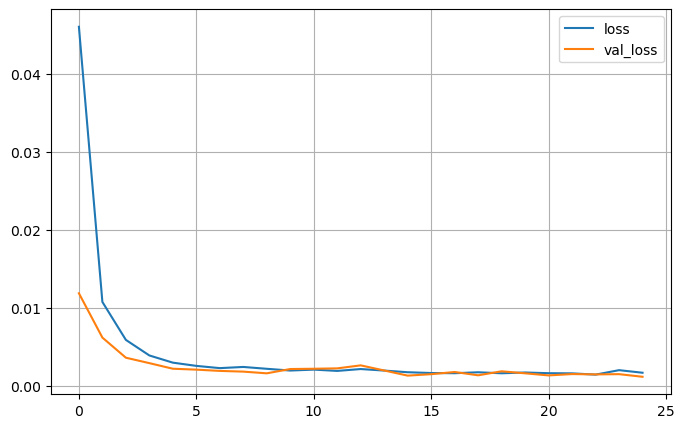

In [13]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [14]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 


0.03478861856070236

In [15]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


In [16]:
y_test_scaled[:3]

array([[0.70202256],
       [0.74801144],
       [0.1341687 ]])

In [17]:
y_pred[:3]

array([[0.6641881 ],
       [0.6957025 ],
       [0.08762773]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [18]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [19]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [20]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [21]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [22]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 00m 18s]
val_loss: 0.0027244454249739647

Best val_loss So Far: 0.0011022533872164786
Total elapsed time: 00h 08m 27s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [23]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 480)            │        77,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 416)            │       200,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 416)            │       173,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           417 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,769 (1.74 MB)

 Trainable params: 456,769 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
num_layers: 5
units_0: 32
units_1: 160
units_2: 480
units_3: 416
units_4: 416
Score: 0.0011022533872164786

Trial 16 summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 448
units_2: 320
units_3: 128
units_4: 128
Score: 0.0011036713840439916

Trial 17 summary
Hyperparameters:
num_layers: 4
units_0: 128
units_1: 352
units_2: 480
units_3: 512
units_4: 352
Score: 0.001117501873522997

Trial 03 summary
Hyperparameters:
num_layers: 5
units_0: 64
units_1: 416
units_2: 320
units_3: 32
units_4: 32
Score: 0.0011244412744417787

Trial 08 summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 384
units_2: 384
units_3: 448
units_4: 416
Score: 0.0011352698784321547

Trial 15 summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 480
units_2: 416
units_3: 32
units_4: 480
Score: 0.0011427912977524102

Trial 09 summary
Hyperparameters:
nu

In [25]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010     


0.03206282983716214

In [26]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [27]:
y_test_scaled[:3]

array([[0.70202256],
       [0.74801144],
       [0.1341687 ]])

In [28]:
y_pred[:3]

array([[0.64410603],
       [0.7619422 ],
       [0.09316104]], dtype=float32)

In [29]:
best_model.save("best_model.keras")